# Group Assignment 1, SA1 - Group 13
**Team Member:** Tommy Kangdra (A0218866N), Xie Tian (A0218829R) Cao Jiaqi (A0218896J)

### 0.0 Importing the Library and the Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing 
from statsmodels.api import add_constant

#Initialize the Variable with starting values 
data_list = (glob.glob("C:/Users/tommy/OneDrive/(PYTHON)/5106/Group Assignment 1/5106 Tommy/Condominium Notebook/Resale/*.csv"))
df_all = pd.DataFrame()

In [2]:
#Appending all other datas with additional values
for n in range(55):
    df = pd.read_csv(data_list[n])
    df_all = pd.concat([df_all,df], axis=0, ignore_index = True)
    

In [3]:
df_all.head(2)

,Project Name,Address,No. of Units,Area (sqm),Type of Area,Transacted Price ($),Nett Price($),Unit Price ($ psm),Unit Price ($ psf),Sale Date,Property Type,Tenure,Completion Date,Type of Sale,Purchaser Address Indicator,Postal District,Postal Sector,Postal Code,Planning Region,Planning Area
0,AZALEA PARK CONDOMINIUM,14 Flora Road #02-02,1,140,Strata,1250000,-,8929,829,11-SEP-2020,Condominium,999 Yrs From 12/10/1885,1996,Resale,Private,17,50,509731,East Region,Pasir Ris
1,RIS GRANDEUR,23 Elias Road #04-07,1,143,Strata,1420000,-,9930,923,11-SEP-2020,Condominium,Freehold,2005,Resale,Private,18,51,519930,East Region,Pasir Ris


In [4]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51530 entries, 0 to 51529
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Project Name                 51530 non-null  object
 1   Address                      51530 non-null  object
 2   No. of Units                 51530 non-null  int64 
 3   Area (sqm)                   51530 non-null  int64 
 4   Type of Area                 51530 non-null  object
 5   Transacted Price ($)         51530 non-null  int64 
 6   Nett Price($)                51530 non-null  object
 7   Unit Price ($ psm)           51530 non-null  int64 
 8   Unit Price ($ psf)           51530 non-null  int64 
 9   Sale Date                    51530 non-null  object
 10  Property Type                51530 non-null  object
 11  Tenure                       51530 non-null  object
 12  Completion Date              51530 non-null  object
 13  Type of Sale                 51

In [5]:
df_all.head(2)

,Project Name,Address,No. of Units,Area (sqm),Type of Area,Transacted Price ($),Nett Price($),Unit Price ($ psm),Unit Price ($ psf),Sale Date,Property Type,Tenure,Completion Date,Type of Sale,Purchaser Address Indicator,Postal District,Postal Sector,Postal Code,Planning Region,Planning Area
0,AZALEA PARK CONDOMINIUM,14 Flora Road #02-02,1,140,Strata,1250000,-,8929,829,11-SEP-2020,Condominium,999 Yrs From 12/10/1885,1996,Resale,Private,17,50,509731,East Region,Pasir Ris
1,RIS GRANDEUR,23 Elias Road #04-07,1,143,Strata,1420000,-,9930,923,11-SEP-2020,Condominium,Freehold,2005,Resale,Private,18,51,519930,East Region,Pasir Ris


## 1.0 Feature Engineering 

In [6]:
# Getting the Level
df_all['Level'] = df_all['Address'].str.split('#').str.get(1).str.split('-').str.get(0)
df_all.fillna(0, inplace = True)

In [7]:
# Removing the B1 data and the 1.6e08 transaction price, for better data understanding 
iddrop = df_all[(df_all['Level'] == 'B1') | (df_all['Level'] == 'B2')].index
df_all.drop(index = iddrop, axis = 0, inplace=True)
iddrop2 = df_all[df_all['Transacted Price ($)'] > 150000000].index
df_all.drop(index = iddrop2, axis = 0, inplace=True)

In [8]:
df_all['Property Type'].value_counts()

Condominium              32979
Apartment                14310
Executive Condominium     3124
Terrace House              803
Semi-Detached House        186
Detached House              73
Name: Property Type, dtype: int64

In [9]:
# Changin the astype to integer
df_all['Level']=df_all['Level'].astype(int)

# Dropping some unused or redundant columns
# dcol = ['Project Name', 'Address', 'No. of Units', 'Nett Price($)', 'Unit Price ($ psm)',
#        'Unit Price ($ psf)', 'Purchaser Address Indicator',
#        'Postal District', 'Postal Sector']
# df_all.drop(labels = dcol, axis=1, inplace=True)

# Renaming columns into easier
df_all.rename({'Area (sqm)' : 'Area', 'Transacted Price ($)':'Price' }, inplace=True, axis=1)

# Removing unknown Completion Date
iddrop = df_all[df_all['Completion Date'] == 'Unknown'].index
df_all.drop(index= iddrop, axis = 0, inplace=True)
df_all['Completion Date'] = df_all['Completion Date'].astype(int)

# Getting the Year from Sale Date
df_all['Sale Year'] = pd.to_datetime(df_all['Sale Date']).dt.year
df_all['Age'] = df_all['Sale Year'] - df_all['Completion Date']

# Add constant
df_all = add_constant(df_all, has_constant='add')

# Tenure 
df_all['Tenure'] = df_all['Tenure'].str.split(' ').str.get(0)
df_all['Tenure'] = df_all['Tenure'].map({'999' : '999', 'Freehold' : 'Freehold', 
                      '99' : '99', '946':'999', '103':'99', 
                      '956' :'999', '9999' : 'Freehold', '102' : '99', 
                      '929' :'999', '947': '999'})

# Covid-19 after March 2020
df_all['Sale Date'] = pd.to_datetime(df_all['Sale Date'])
df_all.loc[df_all['Sale Date'] >= '2020-03-01', 'Covid19'] = 1
df_all.loc[df_all['Sale Date'] < '2020-03-01', 'Covid19'] = 0

# High Price Area
Highpricearea = ['Newton', 'Orchard', 'River Valley', 'Southern Island', 'Tanglin']
ind = []
for x in Highpricearea:
    for i in df_all[df_all['Planning Area'] == x].index:
        ind.append(i)

df_all['High_Price'] = 0
df_all.loc[ind, 'High_Price']  = 1

# Adding Minimum Distance to MRT from Distance Matrix
dist_matrix = pd.read_csv('condo-mrt-distance.csv')
dist_matrix2 = dist_matrix[['Postal Code', 'Minimum']]
df_all= df_all.merge(dist_matrix2, left_on = 'Postal Code', right_on = 'Postal Code', how = 'left')
df_all.dropna(inplace=True)

df_all.head(2)

,const,Project Name,Address,No. of Units,Area,Type of Area,Price,Nett Price($),Unit Price ($ psm),Unit Price ($ psf),...,Postal Sector,Postal Code,Planning Region,Planning Area,Level,Sale Year,Age,Covid19,High_Price,Minimum
0,1.0,AZALEA PARK CONDOMINIUM,14 Flora Road #02-02,1,140,Strata,1250000,-,8929,829,...,50,509731,East Region,Pasir Ris,2,2020,24,1.0,0,0.97
1,1.0,RIS GRANDEUR,23 Elias Road #04-07,1,143,Strata,1420000,-,9930,923,...,51,519930,East Region,Pasir Ris,4,2020,15,1.0,0,1.08


In [10]:
pd.set_option("display.max_rows", 10, "display.max_columns", 10)
dist_matrix

,Postal Code,Jurong East,Bukit Batok,Bukit Gombak,Choa Chu Kang,...,Samudera,Nibong,Sumang,Soo Teck,Minimum
0,18965,12.60,12.51,12.83,15.21,...,14.23,13.73,13.31,12.94,0.06
1,18985,13.45,13.29,13.55,15.84,...,13.69,13.19,12.77,12.40,0.33
2,78878,12.12,10.60,9.96,10.29,...,7.92,7.56,7.25,7.01,1.11
3,78882,12.31,10.78,10.14,10.43,...,7.74,7.38,7.07,6.83,1.09
4,79903,15.83,14.48,13.95,14.44,...,4.48,4.01,3.62,3.29,0.61
...,...,...,...,...,...,...,...,...,...,...,...
3141,828840,19.67,18.24,17.64,17.81,...,0.98,0.60,0.51,0.67,0.23
3142,828841,19.65,18.22,17.61,17.79,...,1.01,0.62,0.51,0.65,0.20
3143,828842,19.62,18.19,17.59,17.77,...,1.03,0.64,0.51,0.63,0.17
3144,828843,19.57,18.15,17.54,17.73,...,1.04,0.63,0.47,0.58,0.15


In [11]:
df_all['Age_0_5'] = 0
df_all.loc[df_all['Age'].between(0,5), 'Age_0_10'] = 1

df_all['Age_5_10'] = 0
df_all.loc[df_all['Age'].between(5,10), 'Age_5_10'] = 1


df_all['Age_10_20'] = 0
df_all.loc[df_all['Age'].between(10,20), 'Age_10_20'] = 1

df_all['Age_20_40'] = 0
df_all.loc[df_all['Age'].between(20,40), 'Age_20_40'] = 1

df_all['Age_40_above'] = 0
df_all.loc[df_all['Age'] > 40, 'Age_40_above'] = 1

df_all['Property Type'].value_counts()

Condominium              26412
Apartment                 9684
Executive Condominium     2862
Terrace House              179
Semi-Detached House         49
Detached House              18
Name: Property Type, dtype: int64

## 2.0 Data Exploration & Visualization

Text(0.5, 1.0, 'Scatter Plot of Distance vs Price')

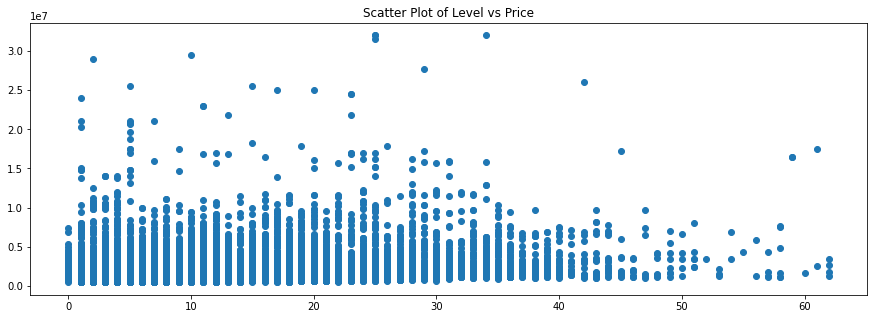

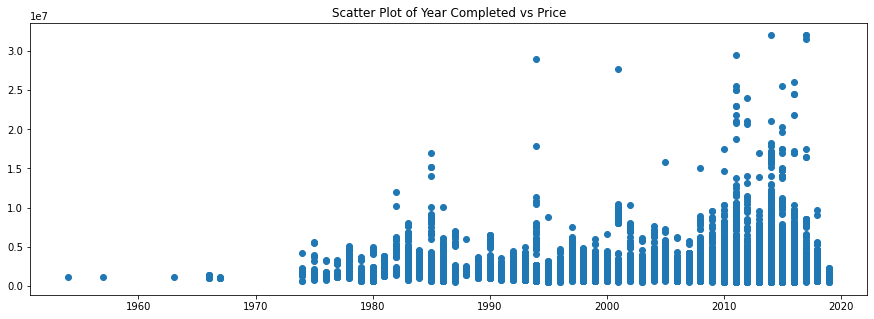

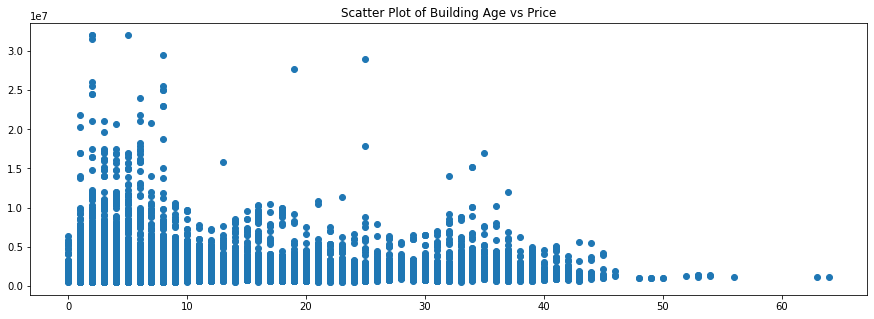

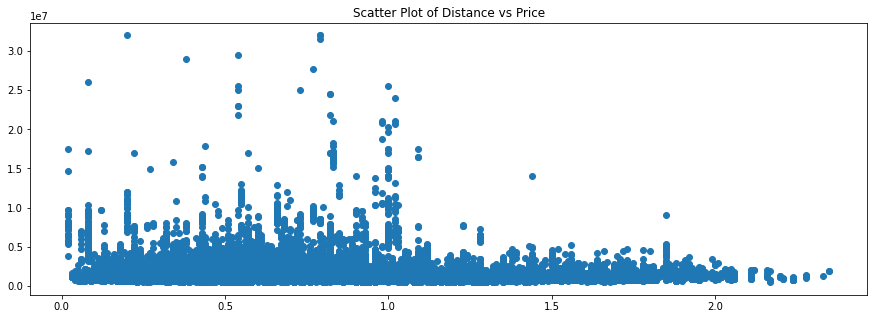

In [12]:
# Plotting the data
plt.figure(figsize = (15,5))
plt.scatter(df_all['Level'], df_all['Price'])
plt.title('Scatter Plot of Level vs Price')
plt.figure(figsize = (15,5))
plt.scatter(df_all['Completion Date'], df_all['Price'])
plt.title('Scatter Plot of Year Completed vs Price')
plt.figure(figsize = (15,5))
plt.scatter(df_all['Age'], df_all['Price'])
plt.title('Scatter Plot of Building Age vs Price')
plt.figure(figsize = (15,5))
plt.scatter(df_all['Minimum'], df_all['Price'])
plt.title('Scatter Plot of Distance vs Price')

Text(0.5, 1.0, 'Line Plot of Average Price vs Area')

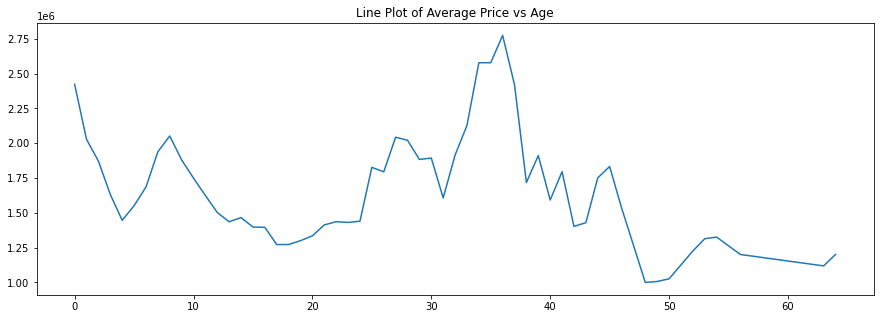

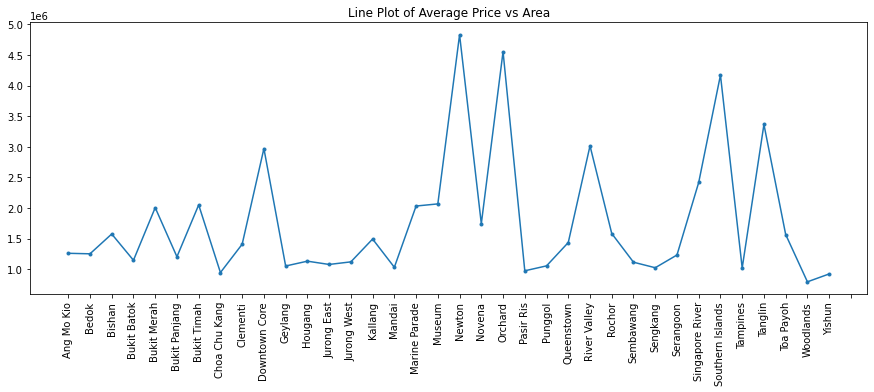

In [13]:
# time plot figure
plt.figure(figsize = (15,5))
plt.plot(df_all[['Age', 'Price']].groupby('Age').mean())
plt.title('Line Plot of Average Price vs Age')

plt.figure(figsize = (15,5))
plt.plot(df_all[['Price', 'Planning Area']].groupby('Planning Area').mean(), marker = '.')
plt.xticks(ticks = range(37), rotation = 90)
plt.title('Line Plot of Average Price vs Area')

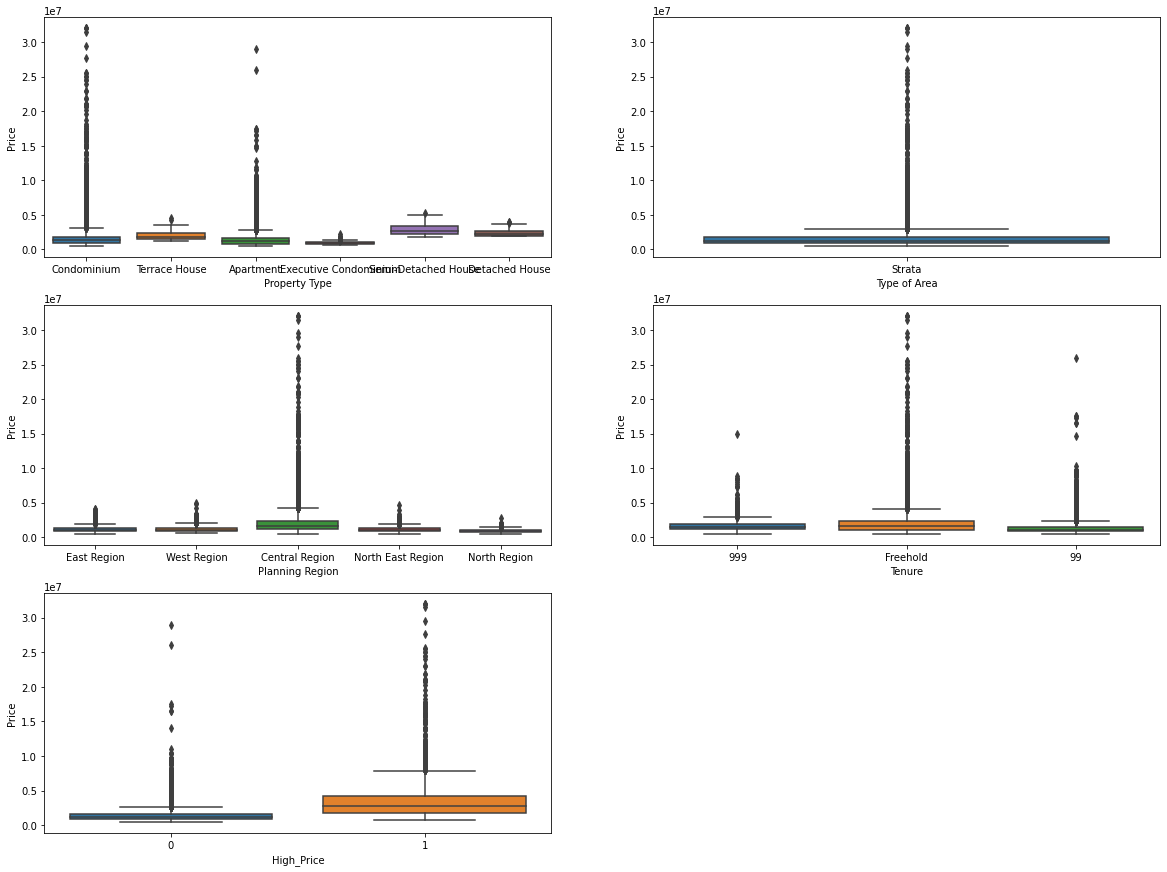

In [14]:
# Exploring the dataset

plt.figure(figsize=(20,15))

plt.subplot(321)
sns.boxplot(x="Property Type", y="Price", data=df_all)

plt.subplot(322)
sns.boxplot(x="Type of Area", y="Price", data=df_all)

plt.subplot(323)
sns.boxplot(x="Planning Region", y="Price", data=df_all)

plt.subplot(324)
sns.boxplot(x="Tenure", y="Price", data=df_all)

plt.subplot(325)
sns.boxplot(x="High_Price", y="Price", data=df_all)

In [15]:
print(df_all[['Tenure', 'Price']].groupby('Tenure').mean())
print(df_all[['Covid19', 'Price']].groupby('Covid19').mean())

                 Price
Tenure                
99        1.311842e+06
999       1.619864e+06
Freehold  2.092730e+06
                Price
Covid19              
0.0      1.625813e+06
1.0      1.529790e+06


In [16]:
# Getting dummies and renaming columns
df_all = pd.get_dummies(df_all, columns=['Property Type', 'Planning Region', 'Tenure'], prefix=['P', 'R', 'T'])

df_all.rename({'R_Central Region' : "R_Central", 'R_East Region' : 'R_East', 'R_North East Region' :'R_NE',
       'R_North Region' : 'R_North', 'R_West Region' : 'R_West'}, inplace=True, axis=1)
df_all.rename({'P_Detached House' : 'P_Detached', 'P_Executive Condominium' : 'P_EC', 
               'P_Semi-Detached House' : 'P_Semidetached', 'P_Terrace House' : 'P_Terrace'}
              , inplace=True, axis=1)

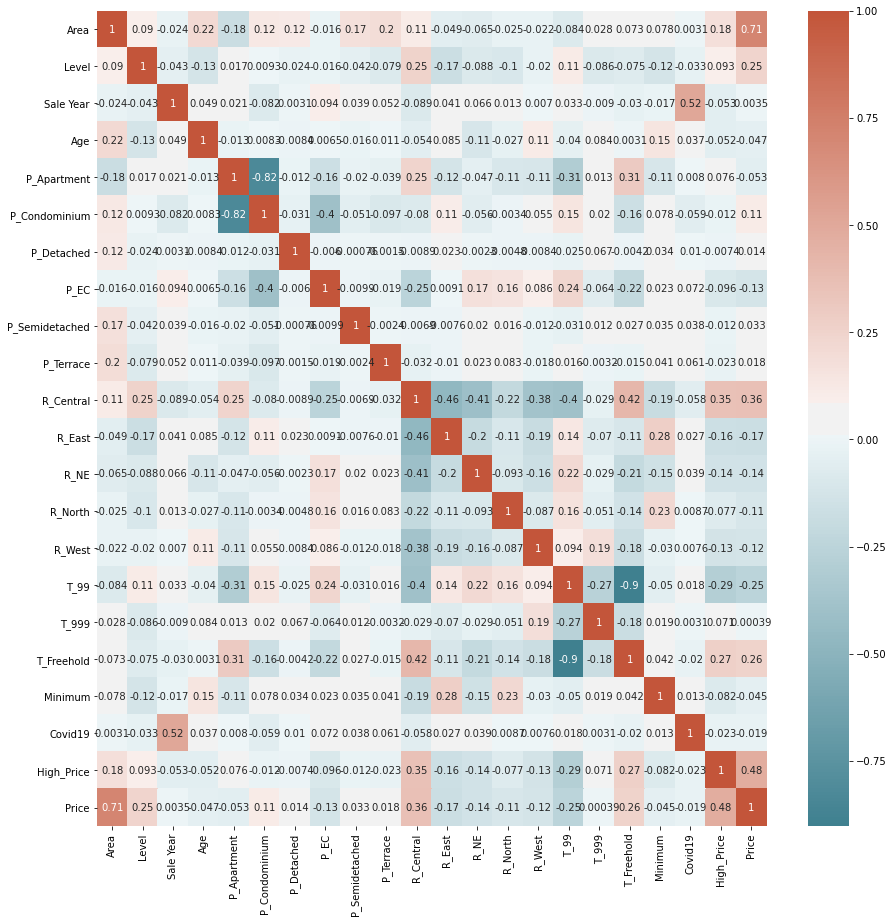

In [17]:
data_viz = df_all[['Area', 'Type of Sale', 'Planning Area', 'Level', 'Sale Year', 'Age', 
       'P_Apartment', 'P_Condominium', 'P_Detached','P_EC', 'P_Semidetached', 'P_Terrace',
       'R_Central', 'R_East', 'R_NE', 'R_North', 'R_West', 
       'T_99', 'T_999', 'T_Freehold', 'Minimum', 'Covid19', 'High_Price', 'Price']]
plt.figure(figsize = (20,20))
cmap = sns.diverging_palette(215, 20, as_cmap=True)
sns.heatmap(data_viz.corr(), cmap=cmap, annot = True)

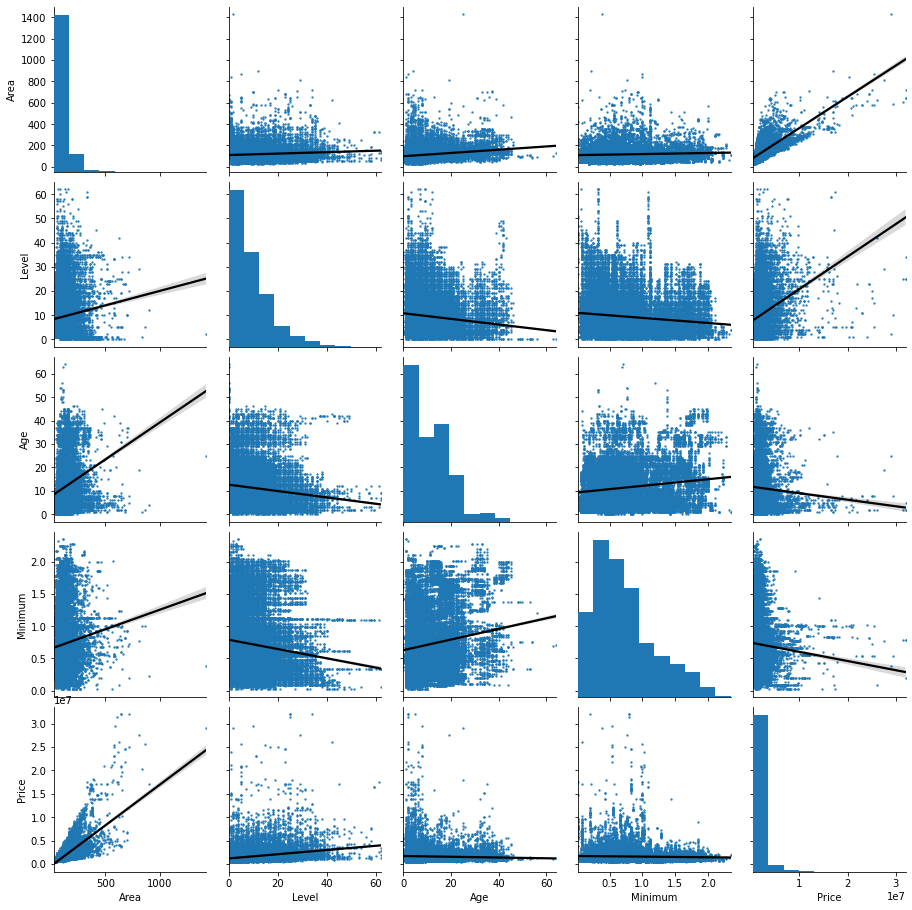

In [18]:
data_viz2 = df_all[['Area', 'Level', 'Age', 'Minimum','Price']]
sns.pairplot(data_viz2, kind="reg", plot_kws=dict(scatter_kws=dict(s=2), line_kws = {'color':'black'}))

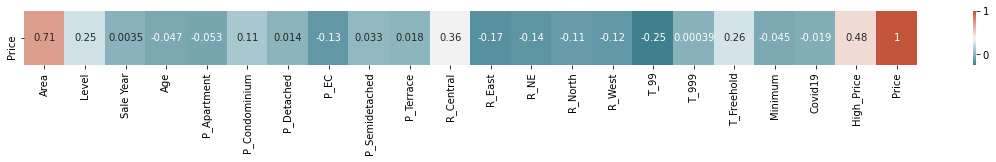

In [19]:
data_viz = df_all[['Area', 'Type of Sale', 'Planning Area', 'Level', 'Sale Year', 'Age', 
       'P_Apartment', 'P_Condominium', 'P_Detached','P_EC', 'P_Semidetached', 'P_Terrace',
       'R_Central', 'R_East', 'R_NE', 'R_North', 'R_West', 
       'T_99', 'T_999', 'T_Freehold', 'Minimum', 'Covid19', 'High_Price', 'Price']]
plt.figure(figsize = (20,1))
cmap = sns.diverging_palette(215, 20, as_cmap=True)
sns.heatmap(data_viz.corr().iloc[-1:,:], cmap=cmap, annot = True)

## 3.0 Modeling with OLS

In [20]:
mask = df_all['Age_5_10'] == 1
df_some = df_all[mask]

In [21]:
import statsmodels.formula.api as smf

condominium = smf.ols(formula= 'Price ~ Age*Area + Age*R_West + Age*R_North + Age*R_NE + Age*R_East + Age*R_Central + Age*R_NE + Age*Minimum + Age*Level + Age*P_EC+ Age*P_Semidetached + Age*High_Price + Age*T_Freehold + Age*T_99 + Age*T_999'
                      ,data=df_some).fit()
condominium.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     1168.
Date:                Mon, 28 Sep 2020   Prob (F-statistic):               0.00
Time:                        22:48:56   Log-Likelihood:            -1.6573e+05
No. Observations:               11002   AIC:                         3.315e+05
Df Residuals:                   10976   BIC:                         3.317e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -3.036e+05   8.18e+04     -3.709      0.000   -4.64e+05   -1.43e+05
Age                -2.721e+04   1.16e+04     -2.348      0.019   -4.99e+04   -4497.848
Area                2.222e+04    624.268     35.586      0.000     2.1e+04    2.34e+04
Age:Area            -568.1920     88.286     -6.436      0.000    -741.248    -395.136
R_West             -2.653e+05   1.01e+05     -2.634      0.008   -4.63e+05   -6.79e+04
Age:R_West           1.95e+04   1.37e+04      1.418      0.156   -7452.886    4.64e+04
R_North             5.821e+05   1.62e+05      3.590      0.000    2.64e+05       9e+05
Age:R_North        -1.155e+05   2.52e+04     -4.585      0.000   -1.65e+05   -6.61e+04
R_NE               -1.511e+05   8.88e+04     -1.701      0.089   -3.25e+05     2.3e+04
Age:R_NE            3786.2522   1.36e+04      0.279      0.780   -2.28e+04    3.04e+04
R_East             -6191.0461   8.58e+04     -0.072      0.942   -1.74e+05    1.62e+05
Age:R_East         -2.313e+04   1.25e+04     -1.847      0.065   -4.77e+04    1423.096
R_Central          -4.631e+05      8e+04     -5.793      0.000    -6.2e+05   -3.06e+05
Age:R_Central        8.81e+04   1.11e+04      7.925      0.000    6.63e+04     1.1e+05
Minimum            -5.984e+05   9.39e+04     -6.376      0.000   -7.82e+05   -4.14e+05
Age:Minimum         7.007e+04    1.3e+04      5.390      0.000    4.46e+04    9.56e+04
Level               7279.7809   4748.882      1.533      0.125   -2028.884    1.66e+04
Age:Level           1049.2131    634.227      1.654      0.098    -193.986    2292.412
P_EC               -2.847e+05   1.54e+05     -1.851      0.064   -5.86e+05    1.69e+04
Age:P_EC            3.176e+04    2.6e+04      1.222      0.222   -1.92e+04    8.27e+04
P_Semidetached     -6.693e+06    7.8e+05     -8.576      0.000   -8.22e+06   -5.16e+06
Age:P_Semidetached   3.84e+05   1.01e+05      3.793      0.000    1.86e+05    5.82e+05
High_Price          2.363e+06   1.27e+05     18.669      0.000    2.11e+06    2.61e+06
Age:High_Price     -1.325e+05   1.73e+04     -7.648      0.000   -1.66e+05   -9.85e+04
T_Freehold          4.781e+05   7.08e+04      6.752      0.000    3.39e+05    6.17e+05
Age:T_Freehold     -6.026e+04   9576.779     -6.293      0.000    -7.9e+04   -4.15e+04
T_99               -1.627e+05   6.92e+04     -2.350      0.019   -2.98e+05    -2.7e+04
Age:T_99           -9343.3774   9402.999     -0.994      0.320   -2.78e+04    9088.195
T_999               -6.19e+05   1.26e+05     -4.909      0.000   -8.66e+05   -3.72e+05
Age:T_999           4.239e+04   1.69e+04      2.506      0.012    9229.357    7.56e+04
==============================================================================
Omnibus:                    11266.929   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (J

In [22]:
import statsmodels.formula.api as smf

condominium = smf.ols(formula= 'Price ~ Area + Age*R_West + Age*R_NE + Age*R_Central + Age*R_NE + Age*Minimum + Level+ Age*P_Semidetached + Age*High_Price + Age*T_Freehold'
                      ,data=df_some).fit()
condominium.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     1704.
Date:                Mon, 28 Sep 2020   Prob (F-statistic):               0.00
Time:                        22:48:56   Log-Likelihood:            -1.6577e+05
No. Observations:               11002   AIC:                         3.316e+05
Df Residuals:                   10984   BIC:                         3.317e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1.761e+05   1.16e+05     -1.521      0.128   -4.03e+05    5.08e+04
Area                1.833e+04    141.731    129.303      0.000     1.8e+04    1.86e+04
Age                -1.084e+05   1.66e+04     -6.529      0.000   -1.41e+05   -7.59e+04
R_West             -4.223e+05   1.38e+05     -3.050      0.002   -6.94e+05   -1.51e+05
Age:R_West          6.488e+04   1.91e+04      3.400      0.001    2.75e+04    1.02e+05
R_NE               -3.179e+05   1.25e+05     -2.543      0.011   -5.63e+05   -7.28e+04
Age:R_NE            5.017e+04    1.9e+04      2.643      0.008     1.3e+04    8.74e+04
R_Central          -5.481e+05   1.06e+05     -5.183      0.000   -7.55e+05   -3.41e+05
Age:R_Central        1.26e+05   1.48e+04      8.537      0.000    9.71e+04    1.55e+05
Minimum            -4.894e+05   9.01e+04     -5.434      0.000   -6.66e+05   -3.13e+05
Age:Minimum         5.461e+04   1.25e+04      4.386      0.000    3.02e+04     7.9e+04
Level               1.528e+04   1052.721     14.515      0.000    1.32e+04    1.73e+04
P_Semidetached     -5.488e+06   7.58e+05     -7.237      0.000   -6.97e+06      -4e+06
Age:P_Semidetached  2.092e+05   9.77e+04      2.142      0.032    1.78e+04    4.01e+05
High_Price          2.471e+06   1.23e+05     20.152      0.000    2.23e+06    2.71e+06
Age:High_Price     -1.501e+05   1.67e+04     -8.962      0.000   -1.83e+05   -1.17e+05
T_Freehold          7.044e+05   8.53e+04      8.253      0.000    5.37e+05    8.72e+05
Age:T_Freehold     -5.786e+04   1.16e+04     -4.994      0.000   -8.06e+04   -3.52e+04
==============================================================================
Omnibus:                    11246.356   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2724826.545
Skew:                           4.554   Prob(JB):                         0.00
Kurtosis:                      79.557   Cond. No.                     1.24e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
pd.set_option("display.max_rows", 10, "display.max_columns", None)
df_some['c_age'] = 2020-df_some['Completion Date']
df_some['c_age_3y'] = 2023 -df_some['Completion Date']

<ipython-input-23-4044452d6ef0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_some['c_age'] = 2020-df_some['Completion Date']
<ipython-input-23-4044452d6ef0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_some['c_age_3y'] = 2023 -df_some['Completion Date']


In [24]:
df_some.head(10)

,const,Project Name,Address,No. of Units,Area,Type of Area,Price,Nett Price($),Unit Price ($ psm),Unit Price ($ psf),Sale Date,Completion Date,Type of Sale,Purchaser Address Indicator,Postal District,Postal Sector,Postal Code,Planning Area,Level,Sale Year,Age,Covid19,High_Price,Minimum,Age_0_5,Age_0_10,Age_5_10,Age_10_20,Age_20_40,Age_40_above,P_Apartment,P_Condominium,P_Detached,P_EC,P_Semidetached,P_Terrace,R_Central,R_East,R_NE,R_North,R_West,T_99,T_999,T_Freehold,c_age,c_age_3y
2,1.0,EUHABITAT,320 Jalan Eunos,1,314,Strata,2200000,-,7006,651,2020-09-11,2015,Resale,Private,14,41,415822,Bedok,0,2020,5,1.0,0,0.79,0,1.0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,5,8
4,1.0,THE RIVERINE BY THE PARK,398 Kallang Road #19-02,1,165,Strata,2880000,-,17455,1622,2020-09-11,2010,Resale,Private,12,33,339098,Kallang,19,2020,10,1.0,0,0.32,0,NaN,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,10,13
6,1.0,REZI 26,5A Lorong 26 Geylang #08-10,1,60,Strata,818000,-,13633,1267,2020-09-11,2015,Resale,Private,14,39,398504,Geylang,8,2020,5,1.0,0,0.46,0,1.0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,5,8
7,1.0,RIVERBAY,23 Mar Thoma Road #22-03,1,36,Strata,570000,-,15833,1471,2020-09-11,2014,Resale,HDB,12,32,328704,Kallang,22,2020,6,1.0,0,0.79,0,NaN,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,6,9
11,1.0,LIVIA,73 Pasir Ris Grove #16-28,1,131,Strata,1250000,-,9542,886,2020-09-11,2011,Resale,HDB,18,51,518206,Pasir Ris,16,2020,9,1.0,0,0.74,0,NaN,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,9,12
12,1.0,NV RESIDENCES,83 Pasir Ris Grove #11-01,1,84,Strata,800000,-,9524,885,2020-09-11,2013,Resale,HDB,18,51,518211,Pasir Ris,11,2020,7,1.0,0,0.58,0,NaN,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,7,10
17,1.0,SKY@ELEVEN,5 Thomson Lane #11-02,1,252,Strata,4400000,-,17460,1622,2020-09-11,2010,Resale,Private,11,29,297724,Toa Payoh,11,2020,10,1.0,0,0.72,0,NaN,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,10,13
20,1.0,WATERFRONT ISLE,732 Bedok Reservoir Road #12-15,1,85,Strata,1080000,-,12706,1180,2020-09-11,2015,Resale,HDB,16,47,479262,Bedok,12,2020,5,1.0,0,0.63,0,1.0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,5,8
31,1.0,TWIN WATERFALLS,112 Punggol Walk #02-25,1,85,Strata,888000,-,10447,971,2020-09-10,2015,Resale,Private,19,82,828766,Punggol,2,2020,5,1.0,0,0.36,0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,5,8
34,1.0,SUITES @ PAYA LEBAR,420 Upper Paya Lebar Road #05-17,1,38,Strata,588000,-,15474,1438,2020-09-10,2013,Resale,Private,19,53,534049,Hougang,5,2020,7,1.0,0,0.74,0,NaN,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,7,10


In [25]:
# Creating new dataset of X to predict the return 3 years later
new_df_ols = pd.DataFrame()
new_df_ols = df_some[['const', 'Area', 'Age', 'R_West', 'R_NE', 'R_Central', 
                      'Minimum', 'Level', 'P_EC', 'P_Semidetached', 
                      'T_Freehold', 'High_Price', 'c_age', 'c_age_3y', 'Postal Code']]

age = 'c_age'

new_df_ols['Age:R_West'] = new_df_ols[age] * new_df_ols['R_West']
new_df_ols['Age:R_NE'] = new_df_ols[age] * new_df_ols['R_NE']
new_df_ols['Age:R_Central'] = new_df_ols[age] * new_df_ols['R_Central']
new_df_ols['Age:Minimum'] = new_df_ols[age] * new_df_ols['Minimum']
new_df_ols['Age:P_EC'] = new_df_ols[age] * new_df_ols['P_EC']
new_df_ols['Age:P_Semidetached'] = new_df_ols[age] * new_df_ols['P_Semidetached']
new_df_ols['Age:T_Freehold'] = new_df_ols[age] * new_df_ols['T_Freehold']
new_df_ols['Age:High_Price'] = new_df_ols[age] * new_df_ols['High_Price']

new_df_ols1 =new_df_ols[['const', 'Area', 'c_age', 'R_West', 'Age:R_West', 
                        'R_NE', 'Age:R_NE', 'R_Central', 'Age:R_Central',
                        'Minimum', 'Age:Minimum', 
                        'Level', 
                        'P_Semidetached', 'Age:P_Semidetached',
                        'High_Price', 'Age:High_Price',
                        'T_Freehold', 'Age:T_Freehold']]
X = new_df_ols1.values

# getting the coefficient from the models
cpar = condominium.params

print(X.shape)
print(cpar.shape)

# dot product to get the prediction
y_pred = np.dot(X,cpar)

(11002, 18)
(18,)


<ipython-input-25-37096ada9739>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df_ols['Age:R_West'] = new_df_ols[age] * new_df_ols['R_West']
<ipython-input-25-37096ada9739>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df_ols['Age:R_NE'] = new_df_ols[age] * new_df_ols['R_NE']
<ipython-input-25-37096ada9739>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [26]:
new_df_ols.head()

,const,Area,Age,R_West,R_NE,R_Central,Minimum,Level,P_EC,P_Semidetached,T_Freehold,High_Price,c_age,c_age_3y,Postal Code,Age:R_West,Age:R_NE,Age:R_Central,Age:Minimum,Age:P_EC,Age:P_Semidetached,Age:T_Freehold,Age:High_Price
2,1.0,314,5,0,0,0,0.79,0,0,0,0,0,5,8,415822,0,0,0,3.95,0,0,0,0
4,1.0,165,10,0,0,1,0.32,19,0,0,1,0,10,13,339098,0,0,10,3.20,0,0,10,0
6,1.0,60,5,0,0,1,0.46,8,0,0,1,0,5,8,398504,0,0,5,2.30,0,0,5,0
7,1.0,36,6,0,0,1,0.79,22,0,0,0,0,6,9,328704,0,0,6,4.74,0,0,0,0
11,1.0,131,9,0,0,0,0.74,16,0,0,0,0,9,12,518206,0,0,0,6.66,0,0,0,0


In [27]:
age = 'c_age_3y'

new_df_ols['Age:R_West'] = new_df_ols[age] * new_df_ols['R_West']
new_df_ols['Age:R_NE'] = new_df_ols[age] * new_df_ols['R_NE']
new_df_ols['Age:R_Central'] = new_df_ols[age] * new_df_ols['R_Central']
new_df_ols['Age:Minimum'] = new_df_ols[age] * new_df_ols['Minimum']
new_df_ols['Age:P_EC'] = new_df_ols[age] * new_df_ols['P_EC']
new_df_ols['Age:P_Semidetached'] = new_df_ols[age] * new_df_ols['P_Semidetached']
new_df_ols['Age:T_Freehold'] = new_df_ols[age] * new_df_ols['T_Freehold']
new_df_ols['Age:High_Price'] = new_df_ols[age] * new_df_ols['High_Price']

new_df_ols2 =new_df_ols[['const', 'Area', 'c_age_3y', 'R_West', 'Age:R_West', 
                        'R_NE', 'Age:R_NE', 'R_Central', 'Age:R_Central',
                        'Minimum', 'Age:Minimum', 
                        'Level', 
                        'P_Semidetached', 'Age:P_Semidetached',
                        'High_Price', 'Age:High_Price',
                        'T_Freehold', 'Age:T_Freehold']]
X2 = new_df_ols2.values

# getting the coefficient from the models
cpar = condominium.params

print(X2.shape)
print(cpar.shape)

# dot product to get the prediction
y_pred_3y = np.dot(X2,cpar)

# Feature Engineering to get the prediction after 3 years, and comparing with the actual (%)
new_df_ols['price'] = df_all['Price']
new_df_ols['pred'] = condominium.predict()
new_df_ols['price_now'] = y_pred
new_df_ols['price_3y'] = y_pred_3y

new_df_ols['pred%'] = round((new_df_ols['pred'] - new_df_ols['price'])/new_df_ols['price']*100,1)
new_df_ols['profit%'] = round((new_df_ols['price_3y'] - new_df_ols['price_now'])/new_df_ols['price_now']*100,1)

(11002, 18)
(18,)


<ipython-input-27-fd10dc952e0b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df_ols['Age:R_West'] = new_df_ols[age] * new_df_ols['R_West']
<ipython-input-27-fd10dc952e0b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df_ols['Age:R_NE'] = new_df_ols[age] * new_df_ols['R_NE']
<ipython-input-27-fd10dc952e0b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [28]:
residual = (new_df_ols['pred'] - new_df_ols['price']).values
residual

array([2665349.23727201,   29841.47696068,   83146.78518706, ...,
        322010.60550607, -429446.19706476, -147564.5261332 ])

In [29]:
# filter off the value with off prediction and then check the profit
mask1 = new_df_ols['profit%'] > 0
mask2 = new_df_ols['pred%'].between(-3,3)

new_df_ols['Area'].describe()


profit_df = new_df_ols[mask1 & mask2][['Area', 'c_age_3y', 'Minimum', 'Level', 'High_Price',
       'price', 'pred', 'price_now', 'price_3y', 'pred%', 'profit%', 'Postal Code']]

id = profit_df.index

In [30]:
pd.set_option("display.max_rows", 10, "display.max_columns", None)
new_df_ols.head(10)

,const,Area,Age,R_West,R_NE,R_Central,Minimum,Level,P_EC,P_Semidetached,T_Freehold,High_Price,c_age,c_age_3y,Postal Code,Age:R_West,Age:R_NE,Age:R_Central,Age:Minimum,Age:P_EC,Age:P_Semidetached,Age:T_Freehold,Age:High_Price,price,pred,price_now,price_3y,pred%,profit%
2,1.0,314,5,0,0,0,0.79,0,0,0,0,0,5,8,415822,0,0,0,6.32,0,0,0,0,2200000,4.865349e+06,4.865349e+06,4.669555e+06,121.2,-4.0
4,1.0,165,10,0,0,1,0.32,19,0,0,1,0,10,13,339098,0,0,13,4.16,0,0,13,0,2880000,2.909841e+06,2.909841e+06,2.841485e+06,1.0,-2.3
6,1.0,60,5,0,0,1,0.46,8,0,0,1,0,5,8,398504,0,0,8,3.68,0,0,8,0,818000,9.011468e+05,9.011468e+05,8.557285e+05,10.2,-5.0
7,1.0,36,6,0,0,1,0.79,22,0,0,0,0,6,9,328704,0,0,9,7.11,0,0,0,0,570000,2.495135e+05,2.495135e+05,4.317459e+05,-56.2,73.0
11,1.0,131,9,0,0,0,0.74,16,0,0,0,0,9,12,518206,0,0,0,8.88,0,0,0,0,1250000,1.494958e+06,1.494958e+06,1.290971e+06,19.6,-13.6
12,1.0,84,7,0,0,0,0.58,11,0,0,0,0,7,10,518211,0,0,0,5.80,0,0,0,0,800000,7.103528e+05,7.103528e+05,4.801513e+05,-11.2,-32.4
17,1.0,252,10,0,0,1,0.72,11,0,0,1,0,10,13,297724,0,0,13,9.36,0,0,13,0,4400000,4.404681e+06,4.404681e+06,4.401861e+06,0.1,-0.1
20,1.0,85,5,0,0,0,0.63,12,0,0,0,0,5,8,479262,0,0,0,5.04,0,0,0,0,1080000,8.866097e+05,8.866097e+05,6.646004e+05,-17.9,-25.0
31,1.0,85,5,0,1,0,0.36,2,1,0,0,0,5,8,828766,0,8,0,2.88,8,0,0,0,888000,7.252083e+05,7.252083e+05,6.094784e+05,-18.3,-16.0
34,1.0,38,7,0,1,0,0.74,5,0,0,1,0,7,10,534049,0,10,0,7.40,0,0,10,0,588000,9.121224e+04,9.121224e+04,-1.358400e+05,-84.5,-248.9


In [31]:
profit_df

,Area,c_age_3y,Minimum,Level,High_Price,price,pred,price_now,price_3y,pred%,profit%,Postal Code
335,96,12,0.15,9,0,1358000,1.331326e+06,1.331326e+06,1.408699e+06,-2.0,5.8,357776
471,122,13,0.19,32,0,2160000,2.187305e+06,2.187305e+06,2.271232e+06,1.3,3.8,198784
1150,107,10,0.90,21,0,1300000,1.282237e+06,1.282237e+06,1.299105e+06,-1.4,1.3,679520
1335,154,13,1.35,15,0,2700000,2.705570e+06,2.705570e+06,2.805972e+06,0.2,3.7,439974
1462,86,12,0.35,19,0,1300000,1.301286e+06,1.301286e+06,1.411427e+06,0.1,8.5,319581
...,...,...,...,...,...,...,...,...,...,...,...,...
50165,112,12,0.30,19,0,1628100,1.675713e+06,1.777662e+06,1.879612e+06,2.9,5.7,138638
50175,63,16,0.21,30,0,1060000,1.076631e+06,1.163835e+06,1.251039e+06,1.6,7.5,208745
50399,128,16,1.12,13,0,2190000,2.185479e+06,2.248197e+06,2.310915e+06,-0.2,2.8,437874
50402,86,16,0.61,13,0,1300000,1.261072e+06,1.413812e+06,1.566553e+06,-3.0,10.8,169814


In [32]:
info_df = pd.read_csv('info_df.csv')
info_df.set_index('Unnamed: 0', inplace=True)
info_df = info_df.loc[id]

In [33]:
info_df = pd.read_csv('info_df2.csv')
info_df.head(2)

,Unnamed: 0,Postal Code,Project Name,Property Type,Planning Area,Planning Region
0,0,509731,AZALEA PARK CONDOMINIUM,Condominium,Pasir Ris,East Region
1,1,519930,RIS GRANDEUR,Condominium,Pasir Ris,East Region


In [34]:
profit_df = profit_df.merge(info_df, left_on = 'Postal Code', right_on = 'Postal Code', how = 'left')

In [35]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
profit_df.describe(include= 'all').iloc[:,-4:]

,Project Name,Property Type,Planning Area,Planning Region
count,316,316,316,316
unique,67,3,17,4
top,THE SEA VIEW,Condominium,Marine Parade,Central Region
freq,20,229,80,273
mean,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN


In [36]:
profit_df.drop('Unnamed: 0', axis=1, inplace=True)

profit_df.head(10)

,Area,c_age_3y,Minimum,Level,High_Price,price,pred,price_now,price_3y,pred%,profit%,Postal Code,Project Name,Property Type,Planning Area,Planning Region
0,96,12,0.15,9,0,1358000,1.331326e+06,1.331326e+06,1.408699e+06,-2.0,5.8,357776,WOODSVILLE 28,Apartment,Toa Payoh,Central Region
1,122,13,0.19,32,0,2160000,2.187305e+06,2.187305e+06,2.271232e+06,1.3,3.8,198784,SOUTHBANK,Apartment,Kallang,Central Region
2,107,10,0.90,21,0,1300000,1.282237e+06,1.282237e+06,1.299105e+06,-1.4,1.3,679520,TREE HOUSE,Condominium,Bukit Panjang,West Region
3,154,13,1.35,15,0,2700000,2.705570e+06,2.705570e+06,2.805972e+06,0.2,3.7,439974,ONE AMBER,Condominium,Marine Parade,Central Region
4,86,12,0.35,19,0,1300000,1.301286e+06,1.301286e+06,1.411427e+06,0.1,8.5,319581,TREVISTA,Condominium,Toa Payoh,Central Region
5,106,12,0.31,19,0,1650000,1.667726e+06,1.667726e+06,1.771314e+06,1.1,6.2,319582,TREVISTA,Condominium,Toa Payoh,Central Region
6,425,8,2.00,0,0,2620000,2.611267e+06,2.611267e+06,3.067742e+06,-0.3,17.5,506842,N.A.,Semi-Detached House,Pasir Ris,East Region
7,154,13,1.35,13,0,2750000,2.675011e+06,2.675011e+06,2.775412e+06,-2.7,3.8,439974,ONE AMBER,Condominium,Marine Parade,Central Region
8,135,10,1.12,7,0,1915000,1.860013e+06,1.860013e+06,2.096314e+06,-2.9,12.7,109688,THE INTERLACE,Condominium,Bukit Merah,Central Region
9,137,10,0.14,5,0,1920000,1.971072e+06,1.971072e+06,2.046806e+06,2.7,3.8,158748,ASCENTIA SKY,Condominium,Bukit Merah,Central Region


In [37]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
profit_df.nlargest(10, columns='profit%')

,Area,c_age_3y,Minimum,Level,High_Price,price,pred,price_now,price_3y,pred%,profit%,Postal Code,Project Name,Property Type,Planning Area,Planning Region
11,416,10,1.19,0,0,3180000,3.171384e+06,3.171384e+06,3.873173e+06,-0.3,22.1,266241,ESTRIVILLAS,Semi-Detached House,Bukit Timah,Central Region
6,425,8,2.00,0,0,2620000,2.611267e+06,2.611267e+06,3.067742e+06,-0.3,17.5,506842,N.A.,Semi-Detached House,Pasir Ris,East Region
21,110,10,1.12,15,0,1560000,1.524096e+06,1.524096e+06,1.760396e+06,-2.3,15.5,109687,THE INTERLACE,Condominium,Bukit Merah,Central Region
307,86,11,0.70,9,0,915000,9.259141e+05,1.093401e+06,1.260887e+06,1.2,15.3,328689,BEACON HEIGHTS,Condominium,Kallang,Central Region
169,86,11,0.70,10,0,915000,9.411940e+05,1.108681e+06,1.276167e+06,2.9,15.1,328689,BEACON HEIGHTS,Condominium,Kallang,Central Region
38,414,10,0.92,0,0,2700000,2.719655e+06,2.863002e+06,3.293043e+06,0.7,15.0,554524,VERDANA VILLAS,Semi-Detached House,Serangoon,North East Region
44,414,10,0.92,0,0,2700000,2.719655e+06,2.863002e+06,3.293043e+06,0.7,15.0,554524,VERDANA VILLAS,Semi-Detached House,Serangoon,North East Region
254,89,18,2.01,21,0,1010000,1.032208e+06,1.363431e+06,1.562165e+06,2.2,14.6,128046,BLUE HORIZON,Condominium,Clementi,West Region
75,125,10,1.12,5,0,1600000,1.567424e+06,1.646191e+06,1.882491e+06,-2.0,14.4,109701,THE INTERLACE,Condominium,Bukit Merah,Central Region
47,113,12,1.03,3,0,1510000,1.479207e+06,1.553059e+06,1.774614e+06,-2.0,14.3,573975,CLOVER BY THE PARK,Condominium,Bishan,Central Region


In [38]:
from sklearn.metrics import mean_squared_error 
print(mean_squared_error(df_some['Price'].values, y_pred))

717238051580.0867


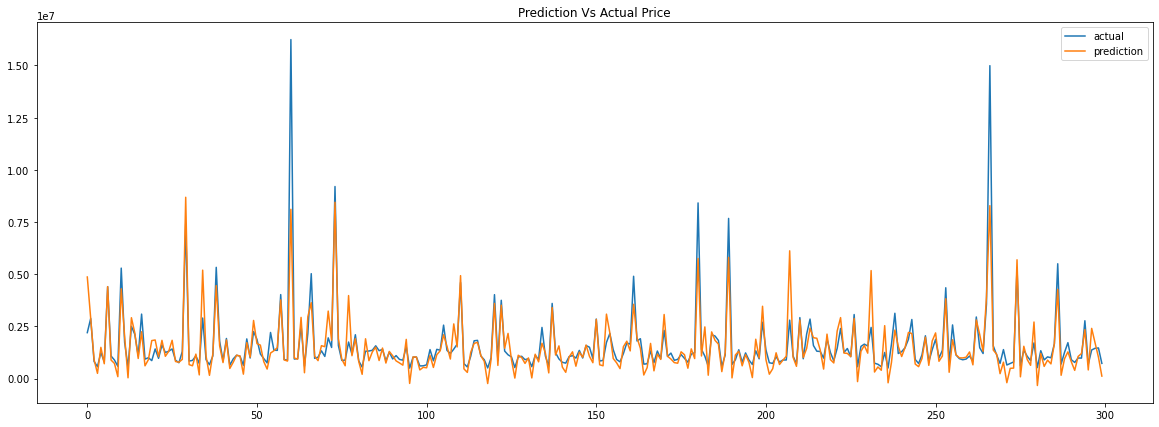

In [39]:
plt.figure(figsize = (20,7))
plt.title('Prediction Vs Actual Price')
plt.plot(range(300), df_some['Price'].iloc[0:300], label = 'actual')
plt.plot(range(300), condominium.predict()[0:300], label = 'prediction')
plt.legend()

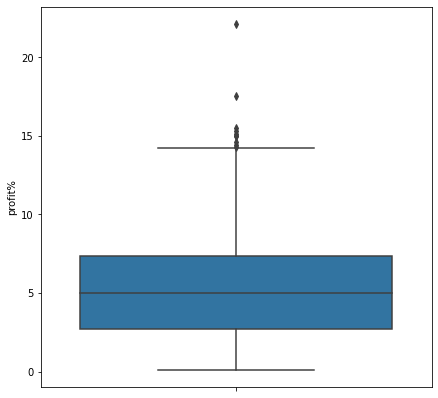

In [40]:
plt.figure(figsize = (7,7))
sns.boxplot(y='profit%', data = profit_df)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text major ticklabel objects>)

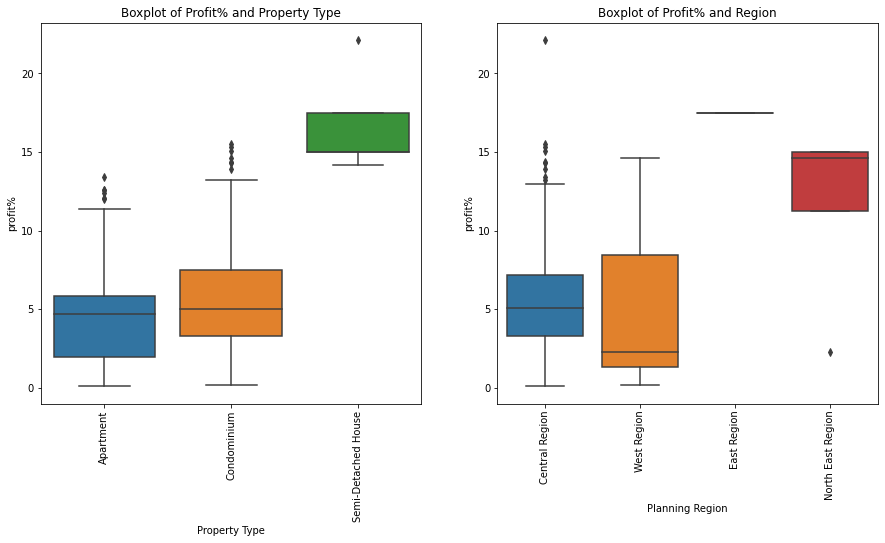

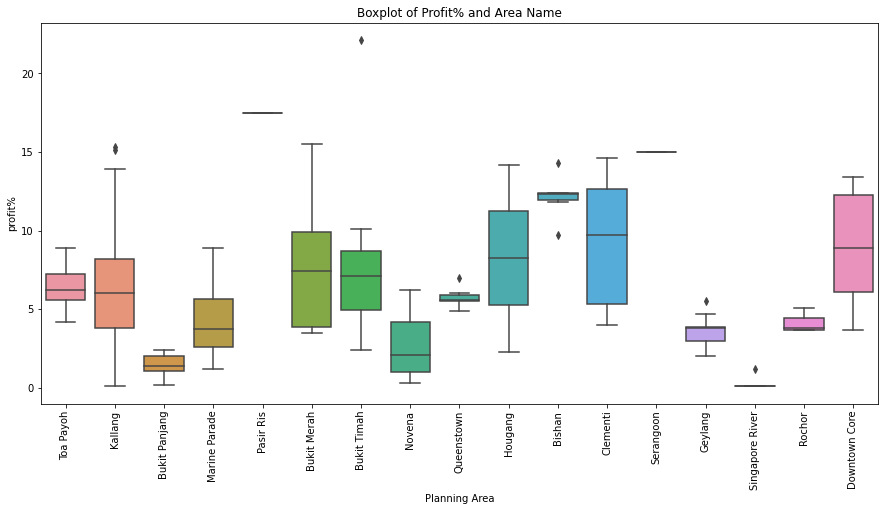

In [41]:
plt.figure(figsize = (15,7))
plt.subplot(121)
plt.title('Boxplot of Profit% and Property Type')
sns.boxplot(y='profit%', x= 'Property Type', data = profit_df)
plt.xticks(rotation = 90)
plt.subplot(122)
plt.title('Boxplot of Profit% and Region')
sns.boxplot(y='profit%', x= 'Planning Region', data = profit_df)
plt.xticks(rotation = 90)
plt.figure(figsize = (15,7))
plt.title('Boxplot of Profit% and Area Name')
sns.boxplot(y='profit%', x= 'Planning Area', data = profit_df)
plt.xticks(rotation = 90)

# Conclusion
- Semi detached house is the most profitable out of the type of condominium
- Though it is shown that the East and North East have a high profitability compared to others, however only several data points in the region that able to reach profitability
- Central Area is a more safer choice, and most profit condominium comes from central area
- From the Area wise some area that is observed with good profitability will be: Clementi, Downtown Core, Hougang, Bukit Merah 